# Introduction

In this notebook, I will guide you a step by step on a journey to predict the future stock price of Apple.Inc based on their previous 10 years' data. 

**N.B: Stock price is an uncertain thing. So, any prediction may drastically differ from the real world value. So, please do not use this for real stock market usage.**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (20.0, 10.0)

# Dataset

We are going to use the [Apple AAPL Historical Stock Dataset](https://www.kaggle.com/tarunpaparaju/apple-aapl-historical-stock-data) and store the data in df variable. We will have a look at the dataset using **df.head()**, it will show the first 5 entries of the dataset. 

In [ ]:
df = pd.read_csv('../input/apple-aapl-historical-stock-data/HistoricalQuotes.csv')
df.head()

# Data Preprocessing

We can see there are many features. Lets check the shape of the dataset using **df.shape**

In [ ]:
df.shape

We are seeing that there are total 2518 rows and 6 columns in the dataset. Now, lets have a deeper look into our dataset to get some more information. We are going to use **df.info()**. This will help us view the datatypes, missing values and many more insights of the dataset and its features. 

In [ ]:
df.info()

Now, lets select one feature to make the problem a univariate one. We will be selecting the **Close/Last** stock price. For that we will use the **df.iloc** and select all the rows and, only the 2nd column. Lets see the new dataframe, df1 using **df1.head()**

In [ ]:
df1 = df.iloc[:,1]
df1.head()

We can see the data in the selected column are not numbers, rather they are objects (currency) as they have Dollar sign as the prefix. Now, we will use regular expression to substitute the Dollar sign with a null '' and typecast the values to float. Let's see how they will look after this preprocessing  

In [ ]:
df1 = df1.replace('[\$,]', '', regex=True).astype(float)
df1.head()

Now, it is time to plot the data. Let's use plt.plot from the matplotlib library to plot the data and visualize the behavior. 

In [ ]:
plt.plot(df1)

It seems that the data has some seasonality and a clear downward trend. But, to be sure about these **seasonality, trend and residuals**, lets use the **statsmodel** and use the **seasonal decompose** to visualize the components of this time series. 

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result  = seasonal_decompose(pd.Series(df1),period=100)

result.plot()
plt.title('Apple Stock')
plt.show()

So, we have now a general idea of the stock price data's behavior. Now, lets Normalize the data. Normalization is a very important part for any **Recurrent Neural Network**. For our LSTM model, normalization will play an important role. Normalization using **MinMaxScaler** will bring our entire datapoints between a minimum and a maximum value. For this purpose, we will use the values **(0,1)**.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))

Now, before applying scaling, lets see the original data shape.

In [ ]:
df1.shape

It is clear that the df1 is a vector. But the problem is MinMaxScaler works on numpy 2D arrays, not on vectors. So, we will convert df1 to 2D array using **np.array(df1).reshape(-1,1))** and then apply the scaling. 

In [ ]:
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
print(df1)
print('\n df1 present shape : ', df1.shape)

We can see above that the data is now scaled and the shape of df1 is 2D. Now, we will move on to the train test splitting. 

# Train Test Split

We will be using a 70%-30% train test split. But before applying splitting, we need to window the data. For that, we will store the training and testing data and their shapes in some variables.

In [ ]:
training_size = int(len(df1)*0.7)
test_size = len(df1) - training_size
print('Training Size : ',training_size)
print('Test Size : ',test_size)

In [ ]:
train_data, test_data = df1[0:training_size,:],df1[training_size:len(df1),:]
print('Training Data Shape : ', train_data.shape)
print('Test Data Shape: ', test_data.shape)

## Windowing Dataset

For better performance of any time series (univariate), it is necessary to use the **splitting window** on the dataset. The concept is simple. We will convert the dataset into several overlapping series. You will have an idea by seeing the picture below. 
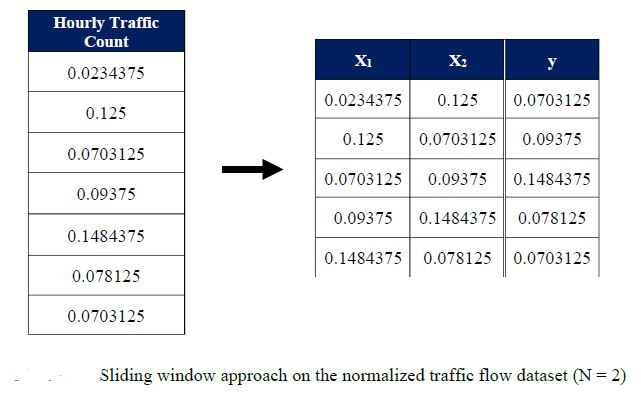
The figure shows the window size = 2. We will be using suitable window size for the best performance. You can try with any number you want. It is a hyperparameter that is needed to be tuned. 

In [ ]:
def create_dataset(dataset, window=1):
    dataX, dataY= [], []
    for i in range(len(dataset)-window-1):
        a = dataset[i:(i+window),0]
        dataX.append(a)
        dataY.append(dataset[i+window,0])
    return np.array(dataX), np.array(dataY)

Lest choose **window size = 100** for now and apply the windowing on training and testing data. 

In [ ]:
window = 100
X_train, y_train = create_dataset(train_data, window=100)
X_test, y_test = create_dataset(test_data, window=100)

To make sure that the sliding window worked, lets check the shape. If the dataset now do not have 100 columns then that means the windowing was not performed properly. 

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

The training and testing data both have 100 columns in their independent variable (X) side. 
At last, before passing the data to the model, we need to reshape the data to make is 3D as LSTM are build to only accept 3D data.  

In [ ]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

# LSTM Model

We will be using the **Sequential, Dense and LSTM layers** to build the model. Ous model will be a **stacked LSTM model**. That means there will be more than one LSTM layer. 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

As it is a regression like problem, so we will be using the **loss='mean_squared_error'**

In [ ]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (100,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer = 'adam')

Lets see the summary of the model.

In [ ]:
model.summary()

# Fitting the data to the model

We now train our model with the training data over 100 epochs and with a batch size = 64

In [ ]:
model.fit(X_train,y_train,validation_data = (X_test,y_test), epochs = 100, batch_size=64,verbose=1)

Now, as the model is trained, lets check its prediction on the test data. We will store the prediction in **y_pred**, but as the data is scaled, so, we will inverse scale the data using **scaler.inverse_transform()** method. 

In [ ]:
y_pred = scaler.inverse_transform(model.predict(X_test))

Lets also inverse scale the y_train data so that we can compare the data.

In [ ]:
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
y_pred[:5]

In [ ]:
y_test[:5]

We can see the first 5 prediction of the model, the prices are very close to the real values. So, we can say that our model has a good accuracy in prediction. So, now lets mathematically check the **error** and **r2 score** to have a idea about how good are model is. 

# Evaluation

In [ ]:
import math
from sklearn.metrics import mean_squared_error

rmse_score = math.sqrt(mean_squared_error(y_test,y_pred))
print('Root Mean Squared Error(test) : ',rmse_score)

As the root mean squared error is only 1.66, it indicates that our model has predicted the stock prices very close to that real values. 

In [ ]:
from sklearn.metrics import r2_score
print('R-squared Score  : ',r2_score(y_test,y_pred))

R-squared Score of 0.99 shows that our model predictionline is very well fitted to the actual line. 

# Visualization

We will now visualize the whole data, training and testing part in a single graph using the following code. 

In [ ]:
# shift train predictions for plotting
train_predict = scaler.inverse_transform(model.predict(X_train))

look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = y_pred
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend()
plt.show()

# Predict 30 Days future value

For predicting the 30 days future values, we need to predict each days values first, then use that value along with 99 others to make a series of 100 (window size is set to 100). The following code does exactly that, and iteratively predicts the 30 days stock value. The values are stored and finally displayed and visualized.

In [ ]:
x_input=test_data[len(test_data)-100:].reshape(1,-1)
x_input.shape

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [ ]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        #print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        #print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

#print(lst_output)

In [ ]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [ ]:
print(scaler.inverse_transform(lst_output))

In [ ]:
plt.plot(day_new,scaler.inverse_transform(df1[len(df1)-100:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

# Conclustion

Our model performed good at predicting the Apple Stock price usign a Stacked LSTM model. This entire notebook can be reused in any stock price prediction with the proper window size. 

At last, I would like to thank Mr. Krish Naik, who has showed me the guideline to make this work done. You can check his channel [here](youtube.com/channel/UCNU_lfiiWBdtULKOw6X0Dig). Also, you can watch his LSTM's video on APple Stock Price Prediction from [this link](https://www.youtube.com/watch?v=H6du_pfuznE&t=1902s).

**At last, I hope, you enjoyed my notebook. If so, then your appreciation will motivate me a lot to write such notebooks in the upcoming days. Thank you.**